# Measuring the Qubit ac-Stark Shift

### Physics Background

Let's consider a qubit with frequency $\omega_q$ strongly coupled to a resonator with frequency $\omega_r$ with $\omega_q<\omega_r$; the qubit-resonator coupling strength is $g$ and the detuning is $\Delta=\omega_q-\omega_r$. In the dispersive limit, the system can be described using the following Hamiltonian: 

$H_{JC(disp)}=\omega_r (a^\dagger a+\frac{1}{2}) + \frac{1}{2} (\omega_q + \frac{g^2}{\Delta} + \frac{2g^2}{\Delta} a^\dagger a) \sigma_z$

where $a$ and $a^\dagger$ are the raising a lowering operators of the resonator photons, and $\sigma_z$ is the Pauli-Z operator acting on the qubit. In this frame the qubit frequency 

$\tilde{\omega}_q=\omega_q + \frac{g^2}{\Delta} + \frac{2g^2}{\Delta} \bar{n}$ 

experiences a constant Lamb shift of $g^2/\Delta$ induced by the vacuum fluctuations in the resonator, and an ac-Stark shift of $(2g^2/\Delta) \bar{n}$ where $\bar{n}=\langle a^\dagger a \rangle$ is the average number of photons present in the resonator. For more details checkout this <a href="https://arxiv.org/abs/cond-mat/0408367">paper</a>.

### 0. Getting started

We'll first get our basic dependencies set up and ready to go.

In [5]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
# Loading your IBM Q account(s)
provider = IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_armonk')

/opt/conda/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


In [6]:
# samples need to be multiples of 16
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)

backend_config = backend.configuration()
backend_defaults = backend.defaults()
dt=backend_config.dt
backend.configuration().parametric_pulses = []

In [7]:
from scipy.optimize import leastsq,minimize, curve_fit

def process_reflective_measurement(freqs,values):
    return np.gradient(np.unwrap(np.angle(values)),freqs)

def lorentzian(f, f0, k, a, offs):
    return a*k/(2*np.pi)/((k/2)**2+(f-f0)**2)+offs

def fit_lorentzian(freqs,values):
    p0=[freqs[np.argmax(values)],(freqs[-1]-freqs[0])/2,max(values),0]
    bounds=([freqs[0],0,0,-np.inf],[freqs[-1],freqs[-1]-freqs[0],np.inf,np.inf])
    popt,pcov=curve_fit(lorentzian, freqs, values, p0=p0, bounds=bounds)
    return popt,pcov

def gaussian(f, f0, sigma, a, offs):
    return a*np.exp(-(f-f0)**2/(2*sigma**2))+offs

def fit_gaussian(freqs,values):
    p0=[freqs[np.argmax(values)],(freqs[-1]-freqs[0])/2,max(values),0]
    bounds=([freqs[0],0,0,-np.inf],[freqs[-1],freqs[-1]-freqs[0],np.inf,np.inf])
    popt,pcov=curve_fit(gaussian, freqs, values, p0=p0, bounds=bounds)
    return popt,pcov

def normalize(a):
    a= a-min(a)
    return a/max(a)

### 1.  ac-Stark Shifting the qubit
In order to ac-Stark shift the qubit we need to populate the resonator with photons using an on-resonance drive. For a drive amplitude $\epsilon$, and a resonator decay rate of $\kappa$, the number of photons in the resonator $\bar{n}=\langle a^\dagger a \rangle = \frac{\epsilon^2}{\Delta^2 +(\kappa/2)^2}$. As a reminder $\tilde{\omega}_q=\omega_q + \frac{g^2}{\Delta} + \delta \omega_q$ where the shift in frequency due to ac_Stark shift is $\delta \omega_q = \frac{2g^2}{\Delta} \bar{n}$. Since $\Delta=\omega_q-\omega_r<0$ the qubit frequency gets smaller as we increase the of photons in the resonator

In [8]:
from qiskit import pulse            # This is where we access all of our Pulse features!
from qiskit.pulse import Play, Acquire
from qiskit.pulse import pulse_lib
import numpy as np

qubit=0

inst_sched_map = backend_defaults.instruction_schedule_map
measure = inst_sched_map.get('measure', qubits=backend_config.meas_map[0])

qubit_drive_sigma = 100e-9
resonator_drive_sigma=10e-9
drive_duration=10*qubit_drive_sigma

qubit_drive = pulse_lib.gaussian(duration = get_closest_multiple_of_16(drive_duration//dt),
                             amp = .1,
                             sigma = get_closest_multiple_of_16(qubit_drive_sigma//dt),
                             name = 'qubit tone')

drive_chan = pulse.DriveChannel(qubit)
meas_chan = pulse.MeasureChannel(qubit)
acq_chan = pulse.AcquireChannel(qubit)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: the pulse_lib module is deprecated, pulse_lib is renamed to library
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
measurement_delay=20e-9

resonator_tone_amplitude = np.linspace(0,1,11) #change to amplitude
resonator_tone_pulses = []
for amp in resonator_tone_amplitude:
    temp_resonator_tone=pulse_lib.GaussianSquare(duration = get_closest_multiple_of_16(drive_duration//dt),
                             amp = amp,
                             sigma = get_closest_multiple_of_16(resonator_drive_sigma//dt),
                             width = get_closest_multiple_of_16((drive_duration-4*resonator_drive_sigma)//dt),
                             name = 'resonator tone')
    
    with pulse.build(name=f"resonator tone power = {np.round(amp,2)} V") as temp_pulse:
        pulse.play(qubit_drive, drive_chan)
        pulse.play(temp_resonator_tone, meas_chan)
        pulse.delay(int(measurement_delay//dt), meas_chan)
        pulse.call(measure)
    
    resonator_tone_pulses.append(temp_pulse)

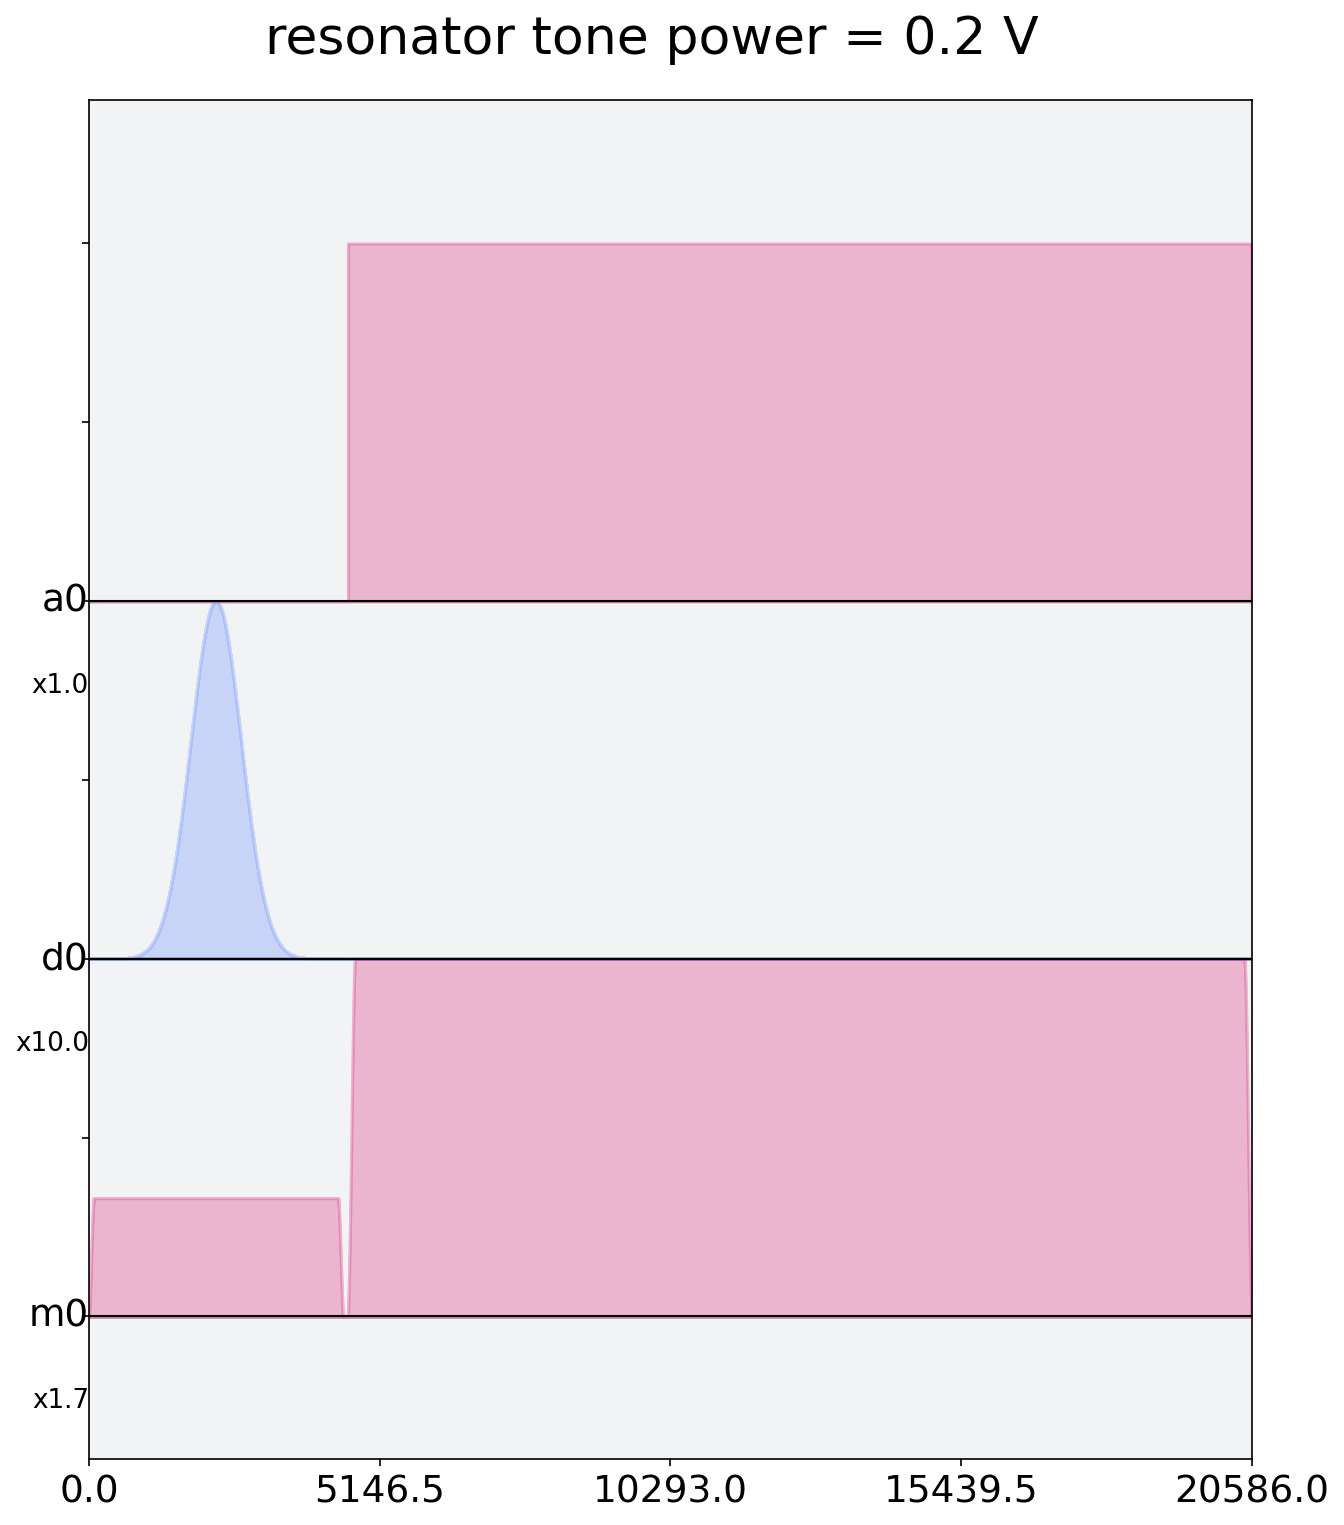

In [11]:
resonator_tone_pulses[2].draw()

In [12]:
#center_freqs = backend_defaults.qubit_freq_est[qubit]
#span=30e6
start=4.960e9
stop=4.980e9
freqs = np.linspace(start, stop, 41)-500e3
schedule_frequencies = [{drive_chan: freq , meas_chan: backend_defaults.meas_freq_est[qubit]} for freq in freqs]

In [13]:
from qiskit import assemble
from qiskit.tools.monitor import job_monitor

num_shots = 4*1024

resonator_tone_experiments=[assemble(resonator_tone_pulses[i],
                            backend=backend, 
                            meas_level=1,
                            meas_return='avg',
                            shots=num_shots,
                            schedule_los= schedule_frequencies) for i in range(len(resonator_tone_pulses))]

resonator_tone_results=[]
for experiment in resonator_tone_experiments:
    job = backend.run(experiment)
    job_monitor(job)
    resonator_tone_results.append(job.result(timeout=120))

/opt/conda/lib/python3.7/site-packages/qiskit/compiler/assemble.py:323: RuntimeWarning: Dynamic rep rates not supported on this backend. rep_time will be used instead of rep_delay.
  RuntimeWarning,


Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


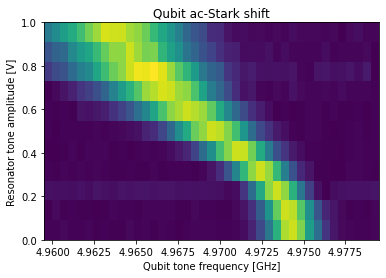

In [14]:
import matplotlib.pyplot as plt

skip_idx=0

resonator_tone_values = []
for result in resonator_tone_results:
    result_values=[]
    for i in range(len(result.results)):
        result_values.append(result.get_memory(i)[qubit])

    resonator_tone_values.append(normalize(result_values))
    #resonator_tone_values.append(np.real(result_values))
    
plot_extent=[freqs[0]/1e9,freqs[-1]/1e9,resonator_tone_amplitude[skip_idx],resonator_tone_amplitude[-1]]
plt.imshow(np.abs(resonator_tone_values[skip_idx:]), aspect='auto', origin='lower', cmap='viridis',
          extent=plot_extent)

plt.xlabel('Qubit tone frequency [GHz]')
plt.ylabel('Resonator tone amplitude [V]')
plt.title('Qubit ac-Stark shift')
plt.show()

### 2.  Qubit frequency shift and linewidth broadening
Using the Jaynes-Cummings model we expect a qubit frequency shift of $\delta \omega_q = \frac{2g^2}{\Delta} \bar{n}$. The qubit frequency experiences fluctuations due the photon shot-noise which leads to qubit linewidth broadening and a dephasing rate of $\Gamma_\phi=\frac{4 \chi^2}{\kappa} \bar{n}$

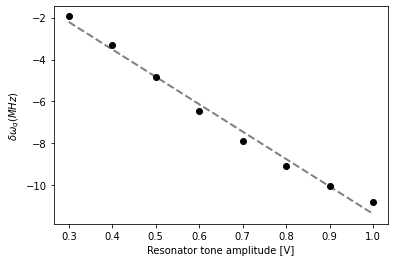

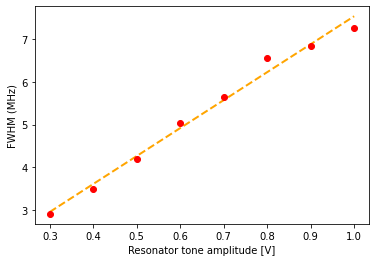

In [15]:
skip_idx=3

center=[]
fwhm=[]
for i in range(len(resonator_tone_values)):
    popt,pcov=fit_gaussian(freqs,np.abs(np.real(resonator_tone_values[i])))
    center.append(popt[0])
    fwhm.append(2.355*popt[1])
    #plt.plot(freqs/1e3, np.real(resonator_tone_values[i]))
    #plt.plot(freqs/1e3, gaussian(freqs,*popt), '--')
#plt.show()

center_fit=np.polyfit(resonator_tone_amplitude[skip_idx:], (center[skip_idx:]-center[0]),1)
plt.plot(resonator_tone_amplitude[skip_idx:], np.poly1d(center_fit/1e6)(resonator_tone_amplitude[skip_idx:]), '--', lw=2, color='grey')
plt.plot(resonator_tone_amplitude[skip_idx:], (center[skip_idx:]-center[0])/1e6, 'o', color='black')
plt.xlabel(r'Resonator tone amplitude [V]')
plt.ylabel(r'$\delta \omega_q (MHz)$')
plt.show()

fwhm_fit=np.polyfit(resonator_tone_amplitude[skip_idx:], np.array(fwhm[skip_idx:]),1)
plt.plot(resonator_tone_amplitude[skip_idx:], np.poly1d(fwhm_fit/1e6)(resonator_tone_amplitude[skip_idx:]), '--', lw=2, color='orange')
plt.plot(resonator_tone_amplitude[skip_idx:], np.array(fwhm[skip_idx:])/1e6, 'o', color='red')
plt.xlabel(r'Resonator tone amplitude [V]')
plt.ylabel(r'FWHM (MHz)')
plt.show()